In [1]:
from util.crossvalidation import cross_test_subject, extract_all_mfcc_features
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data = extract_all_mfcc_features()

In [34]:
def test_clf(target_data, other_data, p):
    label = [1]*len(target_data) + [0]*len(other_data)#
    print("L")
    print(label)
    data = target_data + other_data
    data = np.array(data)
    label = np.array(label)
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.35)
    sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
    sgd_clf.fit(X_train, y_train)
    y_pred = sgd_clf.predict(X_test)
    s = sgd_clf.score(X_test, y_test)
    
    print(y_test)
    
    mtx = metrics.confusion_matrix(y_test, y_pred)
    if len(mtx) == 1:
        mtx = np.array([y_test.count(0),0],[0, y_test.count(1)])
    tn, fp, fn, tp = mtx.ravel()

    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    return s, mtx, sensitivity, specificity

        
        
        

In [35]:
clf_data = {'score': [], 'sensitivity': [], 'specificity': []}
c_mtx = np.array([[0,  0],[ 0,  0]])
for X in range(1, 25):
    c = []
    sen = []
    spec = []
    target_data, negative_sets = cross_test_subject(data, X, 1, 15)
    for set in negative_sets:
        s, mtx, sensitivity, specificity = test_clf(target_data, set, X)
        c_mtx += mtx
        c.append(s)
        sen.append(sensitivity)
        spec.append(specificity)
    clf_data['score'].append(c)
    clf_data['sensitivity'].append(sen)
    clf_data['specificity'].append(spec)


L
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
L
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1]
L
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [33]:
tn, fp, fn, tp = c_mtx.ravel()

print(f"True Negatives:  {tn}")
print(f"True Positives:  {tp}")
print(f"False Negatives: {fn}")
print(f"False Positives: {fp}")

fpr = fp/(fp+tn)
fnr = fn/(fn+tp)

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

youden = sensitivity + specificity - 1

accuracy = (tp+tn)/(tp+tn+fp+fn)

print()
print(f"False Positive Rate: {fpr}")
print(f"False Negative Rate: {fnr}")
print(f"Sensitivity        : {sensitivity}")
print(f"Specificity        : {specificity}")
print(f"Youden Index       : {youden}")
print(f"Accuracy           : {accuracy}")



True Negatives:  1051
True Positives:  6530
False Negatives: 0
False Positives: 149

False Positive Rate: 0.12416666666666666
False Negative Rate: 0.0
Sensitivity        : 1.0
Specificity        : 0.8758333333333334
Youden Index       : 0.8758333333333335
Accuracy           : 0.9807244501940492


In [17]:
print(f"Score: {np.mean(clf_data['score'])}")
print(f"Sensitivity: {np.mean(clf_data['sensitivity'])}")
print(f"Specificity: {np.mean(clf_data['specificity'])}")

Score: 0.995269363092133
Sensitivity: 1.0
Specificity: 0.9931173986713229


In [7]:
y = []
y_sen = []
y_spec = []
er = []
er_sen = []
er_spec = []
for cl in clf_data['score']:
    y.append(np.mean(cl))
    er.append(np.std(cl))
for cl in clf_data['sensitivity']:
    y_sen.append(np.mean(cl))
    er_sen.append(np.std(cl))
for cl in clf_data['specificity']:
    y_spec.append(np.mean(cl))
    er_spec.append(np.std(cl))

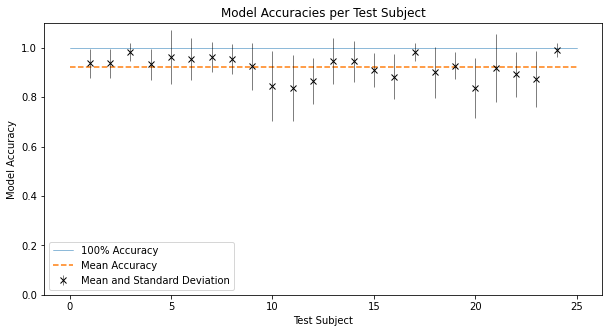

In [10]:
plt.figure(figsize=(10, 5))
plt.title("Model Accuracies per Test Subject")
plt.plot([0,25], [1, 1], "-", linewidth=0.5, label="100% Accuracy")
plt.plot([0,25], [np.mean(clf_data['score']), np.mean(clf_data['score'])], "--", label="Mean Accuracy")
plt.errorbar((list(range(1,25))), y, yerr=er, fmt='x', c="black", elinewidth=0.5, label="Mean and Standard Deviation")
plt.xlabel("Test Subject")
plt.ylabel("Model Accuracy")
plt.ylim(0, 1.1)
plt.legend()
plt.savefig('accuracy_error_plot.png', dpi=300)



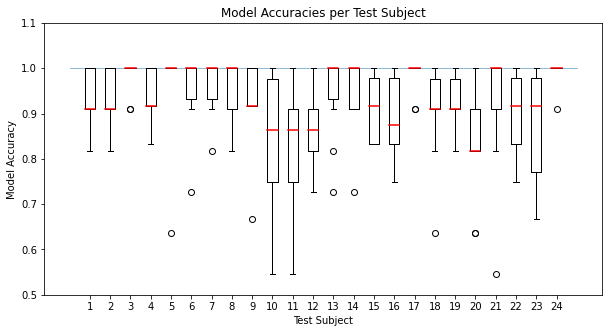

In [13]:
plt.figure(figsize=(10, 5))

plt.plot([0,25], [1, 1], "-", linewidth=0.5, label="100% Accuracy")
plt.title("Model Accuracies per Test Subject")
plt.xlabel("Test Subject")
plt.ylabel("Model Accuracy")
plt.boxplot(np.array(clf_data['score']).T, medianprops=dict(linewidth=1.5, color='red'))
plt.ylim(0.5, 1.1)
plt.savefig('accuracy_box_plot.png', dpi=300)

<BarContainer object of 24 artists>

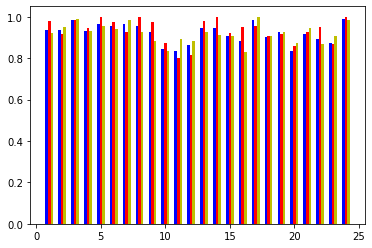

In [16]:
ax = plt.subplot(111)

x = np.array(list(range(1,25)))
ax.bar(x-0.2, y, width=0.2, color='b', align='center')
ax.bar(x, y_sen, width=0.2, color='r', align='center')
ax.bar(x+.2, y_spec, width=0.2, color='y', align='center')

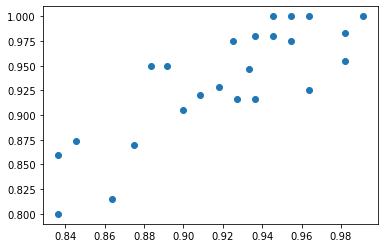

In [17]:
plt.scatter(y, y_sen)

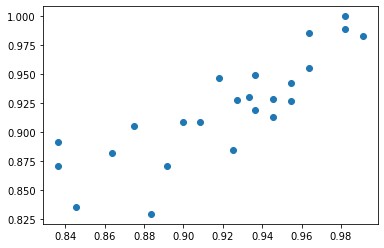

In [18]:
plt.scatter(y, y_spec)